# Projeto Integrador - BitCoin

In [1]:
#######Manipulação de dados e operações matemáticas
import pandas as pd
import numpy as np
import array

#######Padronização de respostas rest
import json
import mysql.connector

#######Api de consulta de CriptoMoedas e Índices 
import yfinance as yf
from mercado_bitcoin import DataAPI

#######Conversão de dados temporais
import datetime as dt

#Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import os
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.widgets import Dropdown
from bokeh.io import curdoc, push_notebook, show, output_notebook
from bokeh.layouts import column, row
from bokeh.models import BooleanFilter, CDSView, Select, Range1d, HoverTool
from bokeh.palettes import Category20
from bokeh.models.formatters import NumeralTickFormatter
from feature_engine import categorical_encoders as ce

#Pre-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


#Otimização de Modelos
import optuna
from sklearn.model_selection import GridSearchCV


#Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb 
import xgboost as xgb 

#Explicação do modelo
import shap 


#modelos --> PRECISA ORGANIZARRRRRRR
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.naive_bayes import GaussianNB

#Avaliação de Modelos
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

/Users/jocasiso/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
###Conexão à base de dados
def getConnection():
    my_db = mysql.connector.connect(
      host="localhost",
      user="root",
      password="root",
      database="coindb",
      port="8888"
    )
    return my_db

###Classe para padronização dos objetos manipulados
class Sumary():
    def __init__(self, coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price):
        self.coin = coin
        self.date = date
        self.opening = opening
        self.closing = closing
        self.lowest = lowest
        self.highest = highest
        self.volume = volume
        self.quantity = quantity
        self.amount = amount
        self.avg_price = avg_price

###Criação padronizada de tabelas
def create_table(coin_name):
    print()
    command = f"CREATE TABLE {coin_name}_day_sumary (id int(11) NOT NULL PRIMARY KEY AUTO_INCREMENT, coin varchar(5) NOT NULL, date date NOT NULL, opening double NOT NULL, closing double NOT NULL, lowest double NOT NULL, highest double NOT NULL, volume double NOT NULL, quantity double NOT NULL, amount double NOT NULL, avg_price double NOT NULL)"
    cnn = getConnection()
    cnn.cursor().execute(f"drop table if exists {coin_name}_day_sumary;")
    cnn.commit()
    cnn.cursor().execute(command)
    cnn.commit()

###Solicita uma lista de papéis ou índices com base em uma data inicial até os dias de hoje
def getStock(stock_array, date_init):
    bag_amount = 20
    bag_control = 0
    date_now = dt.date.today()
    for stock in stock_array:
        bag_control = 0
        cnn = getConnection()
        create_table(stock)
        tickerData = yf.Ticker(stock)
        tickerDf = pd.DataFrame(tickerData.history(start=date_init.strftime("%Y-%m-%d"), end=date_now.strftime("%Y-%m-%d")))
       
        for index, stk in tickerDf.iterrows():
           
            try:
                command = f"INSERT INTO {stock}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{stock}', '{index}', '{stk.Open}', '{stk.Close}', '{stk.Low}', '{stk.High}', '{stk.Volume}', '0', '0', '0')"
                print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
                    #print(calc_date)
            except Exception as e:
                print(e)
                continue
        cnn.commit()
    cnn.commit()

#Solicita o histórico de negociações de uma lista de cryptomoedas com base em uma data inicial    
def getCripto(coin_array, date_init):
    print("Dentro do Cripto")
    cnn = getConnection()
    date_now = dt.date.today()
    print("Calculando a data")
    for coin in coin_array:
        create_table(coin)
        calc_date = date_init
        bag_amount = 20
        bag_control = 0
        #Descomentar se desejar excluir todos os dados anteriores
        #command = f"delete from {coin}_day_sumary"
        #cnn.cursor().execute(command)
        #cnn.commit()
        while calc_date.date() < date_now:
            bag_control += 1
            calc_date += dt.timedelta(days=1)
            if(calc_date.weekday() > 5):
                continue
            sumary_json = DataAPI.day_summary(coin, calc_date.year, calc_date.month, calc_date.day).json()
            sumary_json["coin"] = coin
            try:
                sumary = Sumary(**sumary_json)
                command = f"INSERT INTO {coin}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{sumary.coin}', '{sumary.date}', '{sumary.opening}', '{sumary.closing}', '{sumary.lowest}', '{sumary.highest}', '{sumary.volume}', '{sumary.quantity}', '{sumary.amount}', '{sumary.avg_price}')"
                #print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
            except Exception as e:
                cnn.commit()
                bag_control = 0
                #print(f"Deu erro -> {calc_date} {e}")
            bar.next()
        print("")
        cnn.commit()

#Carrega os dados de uma moeda já existente no banco
def getData(coin):
    conn = getConnection()
    mycursor = conn.cursor()
    query = f"SELECT * FROM {coin}_day_sumary;"
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return myresult

#Carrega os dados do BTC e Indices diretamente do banco    
def get_data_from_db():
    dbColumns = 'btcopening,btcclosing,btcquantity,btcamount,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    #dbColumns = 'btcopening,btcclosing,btclowest,btchighest,btcvolume,btcquantity,btcamount,btcavgprice,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    query = open('data/loaddata.sql').read()
    conn = getConnection()
    mycursor = conn.cursor()
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return pd.DataFrame(myresult, columns=dbColumns)


#EDA Lúcio/Edu
def normal(df, col, threshold=0.05):
    try:
        zscore, p_value = stats.normaltest(df[col])
        if p_value < threshold:
            result = 'not_normal'
        else:
            result = 'normal'
    except:
        zscore = p_value = np.nan
        result = 'not_applicable'
    return result

def outliers_count_IQR(df, col):
    try:
        if len(df[col].unique())>2: # if para eliminar features binárias
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr_range = q3 - q1
            lower = q1 - 1.5*iqr_range
            upper = q3 + 1.5*iqr_range
            out_low = df[df[col] < lower].count()[0]
            out_up = df[df[col] > upper].count()[0]
            outliers = out_low + out_up
            outliers_perc = round(outliers / df.shape[0],2)
        else:
            outliers = np.nan
            outliers_perc = np.nan
    except:
        outliers = np.nan
        outliers_perc = np.nan
    return outliers, outliers_perc


#o que interessa
def EDA_LucioEdu(df):
    df= df.rename(columns=str.lower)

    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    
    colunas = df.columns.tolist()
      
    eda_df['Amount_Unique'] = pd.Series(map(lambda x: len(df[x].unique().tolist()), colunas), index=colunas)

    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['Mean'] = df.mean().round(3)
    eda_df['STD'] = df.std().round(3)
    
    eda_df['Normality'] = pd.Series(map(lambda x: normal(df, x), colunas), index=colunas)
    eda_df['Amount_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[0], colunas), index=colunas)
    eda_df['%_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[1], colunas), index=colunas)
    df = pd.DataFrame(eda_df)
    return df.loc[colunas,:]

#Plotagem padrão do histórico do papel
def plot_stock_price_default(df):
    df = df.reset_index()
    stock = ColumnDataSource(
    data=dict(opening=[], closing=[], highest=[], lowest=[],index=[]))
    stock.data = stock.from_df(df)

    p = figure(plot_width=W_PLOT, plot_height=H_PLOT, tools=TOOLS,
               title="Stock price", toolbar_location='above')

    inc = stock.data['closing'] > stock.data['opening']
    dec = stock.data['opening'] > stock.data['closing']
    view_inc = CDSView(source=stock, filters=[BooleanFilter(inc)])
    view_dec = CDSView(source=stock, filters=[BooleanFilter(dec)])

    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=RED, source=stock, view=view_inc)
    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=GREEN, source=stock, view=view_dec)

    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=BLUE, line_color=BLUE,
           source=stock,view=view_inc, name="avg_price")
    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=RED, line_color=RED,
           source=stock,view=view_dec, name="avg_price")
    
    
    #p.legend.location = "top_left"
    #p.legend.border_line_alpha = 0
    #p.legend.background_fill_alpha = 0
    #p.legend.click_policy = "mute"
    elements = list()
    elements.append(p)

    curdoc().add_root(column(elements))
    curdoc().title = 'Bokeh stocks historical prices'
    show(p, notebook_handle = True)

def plot_stock_closing(df_closing):
    plt.figure(figsize=(22,10))
    plt.plot(df_closing['btc'], label='BitCoin')
    plt.plot(df_closing['dji'], label='DowJones')
    plt.plot(df_closing['dax'], label='DAX-Alemanha')
    #plt.plot(df_closing['hsi'], label='HSI - HongKong')
    plt.legend(loc="upper left", fontsize='large')
    plt.title("Closing Series")
    plt.ylabel("Closing")
    plt.show()
    

#Imprime matriz de correlação
def get_correlation(df):
    corrmat = df.corr()
    sns.set(font_scale=1.0)
    f, ax = plt.subplots(figsize=(15, 10))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corrmat, dtype=bool))
    hm = sns.heatmap(corrmat, 
                 mask=mask,
                 cmap='icefire',
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

def break_date(df, column):
    df['year']   = pd.to_datetime(df[column], format = MY_FORMAT).dt.year
    df['month']  = pd.to_datetime(df[column], format = MY_FORMAT).dt.month
    df['day']    = pd.to_datetime(df[column], format = MY_FORMAT).dt.day
    return df.drop(columns = [column])

#MAPE

def MAPE(y_real, y_pred):
    mape_list = []
    for i in range (0, len(y_real)):
        mape_list.append(np.abs((y_real[i] - y_pred[i])/y_real[i]))
        
    return (np.mean(mape_list))

#Parâmetros para formatação do plot
W_PLOT = 1500
H_PLOT = 600
TOOLS = 'pan,wheel_zoom,reset'
VBAR_WIDTH = 0.2
RED = Category20[7][6]
GREEN = Category20[5][4]
BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]
ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]
MY_FORMAT = '%d/%m/%Y'

#Lista de campos utilizados em um sumário padrão
data_columns = ['id','coin', 'date', 'opening', 'closing', 'lowest', 'highest', 'volume', 'quantity', 'amount', 'avg_price'];

### 1 - Carregando os dados

#### 1.1 - Carregando informações do banco dados

#### 1.2 Carregando dados do CSV

In [3]:
%%time
df = pd.read_csv('bdcsv.csv', sep=',', encoding='utf-8')
display(df.head())
df.shape

,btcopening,btcclosing,btcquantity,btcamount,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,year,month,day,target
0,885.00000,921.84715,76.619064,219.0,23.260702,23.260702,23.260702,23.260702,17833.000000,17833.000000,17833.000000,17833.000000,23857.800781,23857.800781,23857.800781,23857.800781,2015,1,2,0
1,806.00001,788.00000,77.536312,196.0,22.982425,22.120028,22.120028,22.982425,17501.699219,17501.699219,17501.699219,17501.699219,23721.300781,23721.300781,23721.300781,23721.300781,2015,1,5,1
2,788.00002,869.96999,75.642620,277.0,22.120028,22.120028,22.120028,22.120028,17371.599609,17371.599609,17371.599609,17371.599609,23485.400391,23485.400391,23485.400391,23485.400391,2015,1,6,0
3,869.96999,894.37342,128.782582,364.0,22.120028,22.120028,22.120028,22.120028,17584.500000,17584.500000,17584.500000,17584.500000,23681.300781,23681.300781,23681.300781,23681.300781,2015,1,7,0
4,912.07042,905.98343,117.252409,326.0,22.617903,22.742373,22.617903,22.742373,17907.900391,17907.900391,17907.900391,17907.900391,23835.500000,23835.500000,23835.500000,23835.500000,2015,1,8,1


CPU times: user 39.1 ms, sys: 7.73 ms, total: 46.8 ms
Wall time: 70.3 ms


(1303, 20)

### 2 - Análise exploratória de dados

In [4]:
display(df.info())
display(EDA_LucioEdu(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   btcopening   1303 non-null   float64
 1   btcclosing   1303 non-null   float64
 2   btcquantity  1303 non-null   float64
 3   btcamount    1303 non-null   float64
 4   daxopening   1303 non-null   float64
 5   daxclosing   1303 non-null   float64
 6   daxlowest    1303 non-null   float64
 7   daxhighest   1303 non-null   float64
 8   djiopening   1303 non-null   float64
 9   djiclosing   1303 non-null   float64
 10  djilowest    1303 non-null   float64
 11  djihighest   1303 non-null   float64
 12  hsiopening   1303 non-null   float64
 13  hsiclosing   1303 non-null   float64
 14  hsilowest    1303 non-null   float64
 15  hsihighest   1303 non-null   float64
 16  year         1303 non-null   int64  
 17  month        1303 non-null   int64  
 18  day          1303 non-null   int64  
 19  target

None

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Min,Max,Mean,STD,Normality,Amount_Outliers,%_Outliers
btcopening,0,0.0,float64,1303,1284,553.094770,103953.338930,18567.691,20852.652,not_applicable,29.0,0.02
btcclosing,0,0.0,float64,1303,1282,550.000000,103953.339050,18635.532,20963.005,not_applicable,30.0,0.02
btcquantity,0,0.0,float64,1303,1303,11.999820,2629.602778,241.472,213.533,not_applicable,98.0,0.08
btcamount,0,0.0,float64,1303,1115,71.000000,33169.000000,3185.380,3783.943,not_applicable,68.0,0.05
daxopening,0,0.0,float64,1303,1286,17.063260,31.733272,25.059,2.862,not_applicable,0.0,0.00
daxclosing,0,0.0,float64,1303,1167,17.186836,31.583763,25.038,2.855,not_applicable,0.0,0.00
daxlowest,0,0.0,float64,1303,1278,16.806224,31.462288,24.924,2.857,not_applicable,0.0,0.00
daxhighest,0,0.0,float64,1303,1268,17.606990,31.770650,25.154,2.853,not_applicable,0.0,0.00
djiopening,0,0.0,float64,1303,1291,15660.200195,30218.300781,21878.498,3806.380,not_applicable,0.0,0.00
djiclosing,0,0.0,float64,1303,1293,15660.200195,30218.300781,21877.254,3805.648,not_applicable,0.0,0.00


### Análise: Efetuando uma análise preliminar dos dados é possível perceber que não possímos valores nulos (NAN) no dataset. Outro ponto importante é o fato de que de acordo pois comparando com os valores mínimos e máximos de cada feature não é possível detectarmos outliers, mesmo que de forma intuitiva. Um problema visível é a grande diferença de escala de algumas características, principalmente entre as features que expressão valores e as que expressão quantidade, como por exemplo btcclosing e btcquantity.

### 3 - Verificando a correlação entre as features

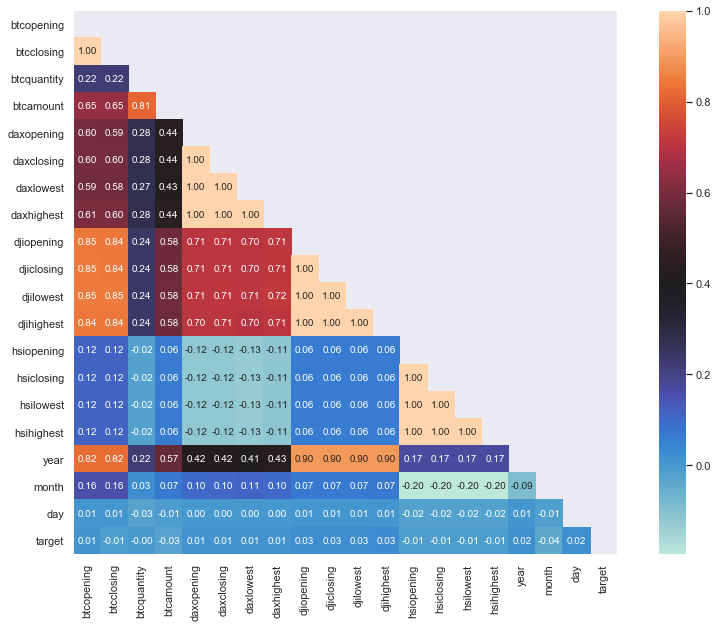

In [5]:
get_correlation(df)

#### 3.1 - Excluindo colunas com alta correlação

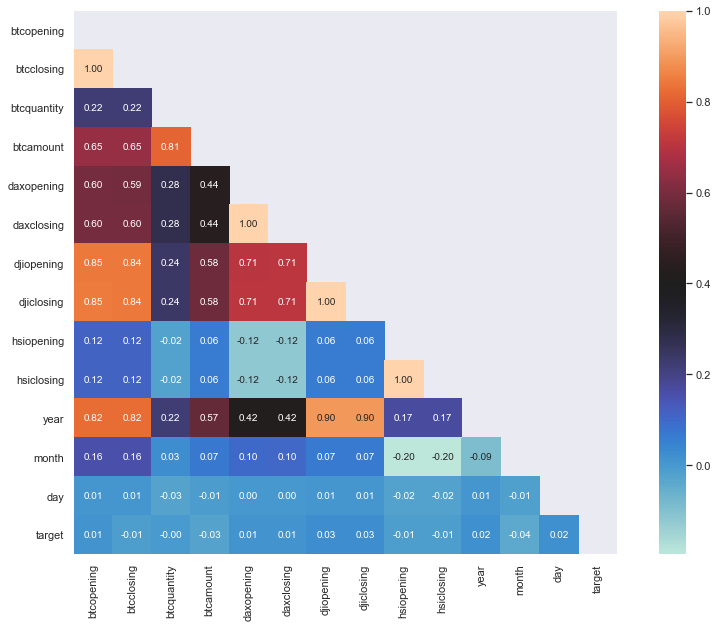

In [6]:
columns_to_remove = ['daxlowest', 'daxhighest','djilowest', 'djihighest','hsilowest', 'hsihighest']
df2 = df.drop(columns = columns_to_remove)
get_correlation(df2)

#### 3.2 - Criando um dataset somente dos fechamentos para verificar graficamente o comportamento da criptomoeda em relação aos índices

,btc,dji,dax,hsi,year,month,day
0,921.84715,17833.000000,23.260702,23857.800781,2015,1,2
1,788.00000,17501.699219,22.120028,23721.300781,2015,1,5
2,869.96999,17371.599609,22.120028,23485.400391,2015,1,6
3,894.37342,17584.500000,22.120028,23681.300781,2015,1,7
4,905.98343,17907.900391,22.742373,23835.500000,2015,1,8


None

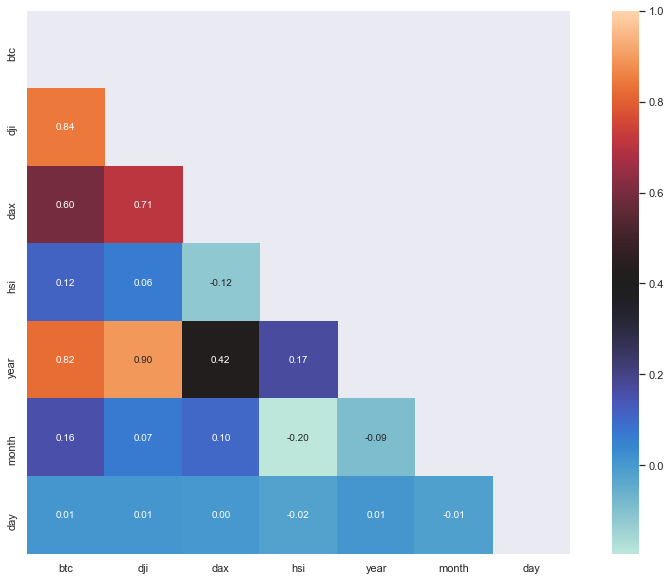

In [7]:
df_closing = pd.DataFrame(columns = ['btc', 'dji', 'dax', 'hsi','year', 'month', 'day'])
df_closing['btc'] = df2['btcclosing']
df_closing['dji'] = df2['djiclosing']
df_closing['dax'] = df2['daxclosing']
df_closing['hsi'] = df2['hsiclosing']
df_closing['year'] = df2['year']
df_closing['month'] = df2['month']
df_closing['day'] = df2['day']
display(df_closing.head())
display(get_correlation(df_closing))

#### 3.3 - Ajustando os dados em uma mesma escala para verificar se existe realmente alguma correlação entre eles no decorrer do tempo

,btc,dji,dax,hsi
0,-0.845322,-1.063106,-0.622808,0.621782
1,-0.851709,-1.150195,-1.022482,0.610431
2,-0.847797,-1.184394,-1.022482,0.590815
3,-0.846633,-1.128429,-1.022482,0.607105
4,-0.846079,-1.043417,-0.804422,0.619927


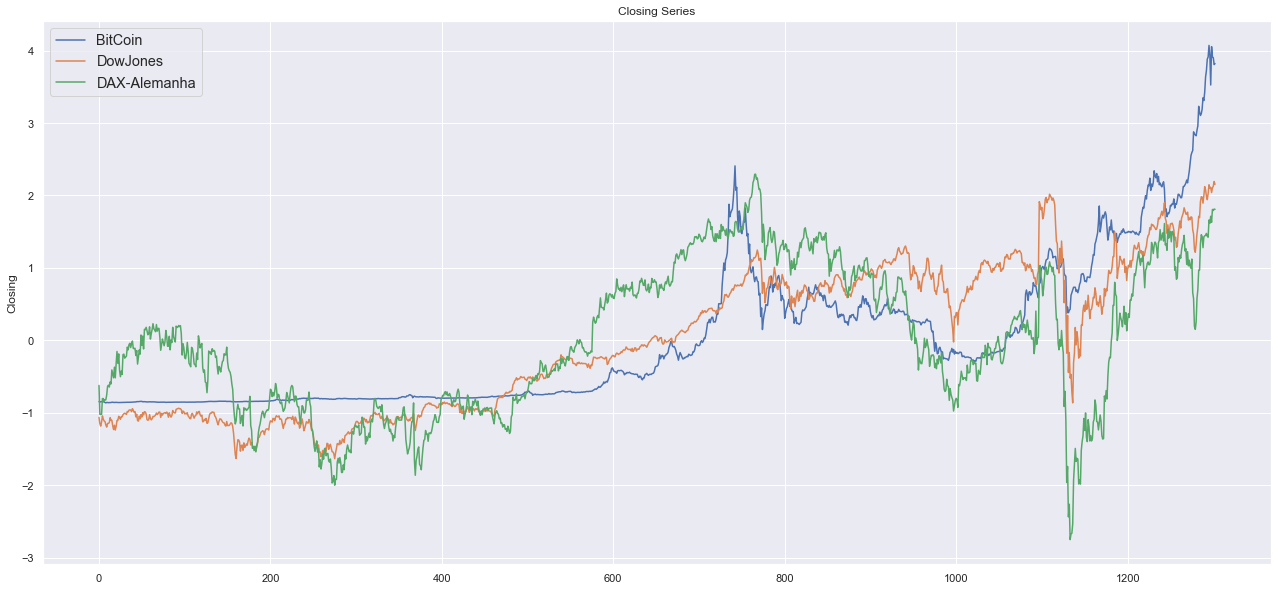

In [8]:
df_closing_scaler = pd.DataFrame(StandardScaler().fit(df_closing).fit_transform(df_closing), columns = df_closing.columns)
df_closing_scaler = df_closing_scaler.drop(columns = ['year', 'month', 'day'])
display(df_closing_scaler.head())
plot_stock_closing(df_closing_scaler)

#### Análise: Após ajustar os dados em uma mesma escala é possível percever que os picos de alta, baixa e a tendência em alguns intervalos são muito semelhantes. Neste sentido, é possivel inferir que existe uma correlação entre os dados em um mesmo momento. Por outro lado, não é possível afirmar que o estado passado das séries represente de alguma o status de fechamento ou os valores futuros do Bitcopin.

### 4 - Feature Engenineering
#### 4.1 - Criando novas features que possibilitem análise de sériers temporais

In [9]:
df_closing_1 = df_closing.drop(columns = 'hsi') #vou dropar essa feature porque está com valores muito estranhos
df_closing_1['day'] = df2['day'].astype(str)
df_closing_1['month'] = df_closing['month'].astype(str)
df_closing_1['year'] = df_closing['year'].astype(str)
df_closing_1['data'] = df_closing_1[['day', 'month', 'year']].agg('-'.join, axis=1)
df_closing_1['day'] = df2['day'].astype(int)
df_closing_1['month'] = df_closing['month'].astype(int)
df_closing_1['year'] = df_closing['year'].astype(int)
df_closing_1['date'] = pd.to_datetime(df_closing_1['data'], format='%d-%m-%Y')
df_closing_1['day_of_year'] = df_closing_1.date.apply(lambda x: x.dayofyear)
df_closing_1['week_of_year'] = df_closing_1.date.apply(lambda x: x.weekofyear)
df_closing_1['day'] = df2['day'].astype(int)
df_closing_1['initial_month'] = np.where(df_closing_1['day'] < 5, 1, 0)
del df_closing_1['data']
df_closing_1.head()

,btc,dji,dax,year,month,day,date,day_of_year,week_of_year,initial_month
0,921.84715,17833.000000,23.260702,2015,1,2,2015-01-02,2,1,1
1,788.00000,17501.699219,22.120028,2015,1,5,2015-01-05,5,2,0
2,869.96999,17371.599609,22.120028,2015,1,6,2015-01-06,6,2,0
3,894.37342,17584.500000,22.120028,2015,1,7,2015-01-07,7,2,0
4,905.98343,17907.900391,22.742373,2015,1,8,2015-01-08,8,2,0


#### 4.2 - Criando Lag Featuers que representam o comportamento semanal e mensal do fechamento dos índices

In [10]:
# podemos ver como está o comportamento esta mudando ao longo do tempo 
# através da média do preço de fechamento semanal e mensal
window5 = 5 #janela semanal, 5 dias úteis
window20 = 20 #janela mensal, aprox 20 dias úteis 
df_closing_2 = df_closing_1.copy()
df_closing_2['week_median_btc'] = df_closing_1['btc'].rolling(window=window5).mean().round(2)
df_closing_2['week_median_dji'] = df_closing_1['dji'].rolling(window=window5).mean().round(2)
df_closing_2['week_median_dax'] = df_closing_1['dax'].rolling(window=window5).mean().round(2)
#df_closing['month_median_btc'] =  df_closing['btc'].rolling(window=window20).mean().round(2)
#df_closing['month_median_dji'] =  df_closing['dji'].rolling(window=window20).mean().round(2)
#df_closing['month_median_dax'] =  df_closing['dax'].rolling(window=window20).mean().round(2)
df_closing_2.head(10)

,btc,dji,dax,year,month,day,date,day_of_year,week_of_year,initial_month,week_median_btc,week_median_dji,week_median_dax
0,921.84715,17833.000000,23.260702,2015,1,2,2015-01-02,2,1,1,NaN,NaN,NaN
1,788.00000,17501.699219,22.120028,2015,1,5,2015-01-05,5,2,0,NaN,NaN,NaN
2,869.96999,17371.599609,22.120028,2015,1,6,2015-01-06,6,2,0,NaN,NaN,NaN
3,894.37342,17584.500000,22.120028,2015,1,7,2015-01-07,7,2,0,NaN,NaN,NaN
4,905.98343,17907.900391,22.742373,2015,1,8,2015-01-08,8,2,0,876.03,17639.74,22.47
5,877.15778,17737.400391,22.742373,2015,1,9,2015-01-09,9,2,0,867.10,17620.62,22.37
6,800.00000,17640.800781,22.626799,2015,1,12,2015-01-12,12,3,0,869.50,17648.44,22.47
7,640.08056,17613.699219,22.697924,2015,1,13,2015-01-13,13,3,0,823.52,17696.86,22.59
8,550.00000,17427.099609,22.697924,2015,1,14,2015-01-14,14,3,0,754.64,17665.38,22.70
9,659.99000,17320.699219,22.890850,2015,1,15,2015-01-15,15,3,0,705.45,17547.94,22.73


#### 4.3 - Criando novas features utilizando a variação semanal e a correlação de cada ítem com o Bitcoin

In [11]:
#variação em % semanal do btc, dji e dax 
df_closing_3 = df_closing_2.copy()
df_closing_3['variacao_sem_btc'] = df_closing_3['btc'].pct_change(window5-1).round(4)
df_closing_3['variacao_sem_dji'] = df_closing_3['dji'].pct_change(window5-1).round(4)
df_closing_3['variacao_sem_dax'] = df_closing_3['dax'].pct_change(window5-1).round(4)
#correlação entre btc e dji e btc e dax
df_closing_3['corr_btc_dji'] = df_closing_3['btc'].rolling(window5).\
            corr(df_closing_3['dji'])
df_closing_3['corr_btc_dax'] = df_closing_3['btc'].rolling(window5).\
            corr(df_closing_3['dax'])
df_closing_3.head(10)

,btc,dji,dax,year,month,day,date,day_of_year,week_of_year,initial_month,week_median_btc,week_median_dji,week_median_dax,variacao_sem_btc,variacao_sem_dji,variacao_sem_dax,corr_btc_dji,corr_btc_dax
0,921.84715,17833.000000,23.260702,2015,1,2,2015-01-02,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,788.00000,17501.699219,22.120028,2015,1,5,2015-01-05,5,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,869.96999,17371.599609,22.120028,2015,1,6,2015-01-06,6,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,894.37342,17584.500000,22.120028,2015,1,7,2015-01-07,7,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,905.98343,17907.900391,22.742373,2015,1,8,2015-01-08,8,2,0,876.03,17639.74,22.47,-0.0172,0.0042,-0.0223,0.623687,0.650945
5,877.15778,17737.400391,22.742373,2015,1,9,2015-01-09,9,2,0,867.10,17620.62,22.37,0.1131,0.0135,0.0281,0.518256,0.481211
6,800.00000,17640.800781,22.626799,2015,1,12,2015-01-12,12,3,0,869.50,17648.44,22.47,-0.0804,0.0155,0.0229,0.274228,-0.144856
7,640.08056,17613.699219,22.697924,2015,1,13,2015-01-13,13,3,0,823.52,17696.86,22.59,-0.2843,0.0017,0.0261,0.485780,-0.283819
8,550.00000,17427.099609,22.697924,2015,1,14,2015-01-14,14,3,0,754.64,17665.38,22.70,-0.3929,-0.0268,-0.0020,0.912935,0.306910
9,659.99000,17320.699219,22.890850,2015,1,15,2015-01-15,15,3,0,705.45,17547.94,22.73,-0.2476,-0.0235,0.0065,0.742477,-0.152177


#### 4.4 - Ajustando o intervalo das features de acordo com a janela de deslocamento e eliminando NANs

In [12]:
#como para prever um alvo, nós também dependenmos de valores futuros das features que temos (que não temos como saber),
#nós fazemos um shift dos dados que temos para pode usar eles para prever o futuro...
df_closing_4 = df_closing_3.copy()
df_closing_4['dji'].shift(periods=window5)
df_closing_4['dax'].shift(periods=window5)
df_closing_4['week_median_btc'].shift(periods=window5)
df_closing_4['week_median_dji'].shift(periods=window5)
df_closing_4['week_median_dax'].shift(periods=window5)
df_closing_4['variacao_sem_btc'].shift(periods=window5)
df_closing_4['variacao_sem_dji'].shift(periods=window5)
df_closing_4['variacao_sem_dax'].shift(periods=window5)
df_closing_4['corr_btc_dji'].shift(periods=window5)
df_closing_4['corr_btc_dax'].shift(periods=window5)
df_closing_4 = df_closing_4.dropna()
df_closing_4.head(10)

,btc,dji,dax,year,month,day,date,day_of_year,week_of_year,initial_month,week_median_btc,week_median_dji,week_median_dax,variacao_sem_btc,variacao_sem_dji,variacao_sem_dax,corr_btc_dji,corr_btc_dax
4,905.98343,17907.900391,22.742373,2015,1,8,2015-01-08,8,2,0,876.03,17639.74,22.47,-0.0172,0.0042,-0.0223,0.623687,0.650945
5,877.15778,17737.400391,22.742373,2015,1,9,2015-01-09,9,2,0,867.10,17620.62,22.37,0.1131,0.0135,0.0281,0.518256,0.481211
6,800.00000,17640.800781,22.626799,2015,1,12,2015-01-12,12,3,0,869.50,17648.44,22.47,-0.0804,0.0155,0.0229,0.274228,-0.144856
7,640.08056,17613.699219,22.697924,2015,1,13,2015-01-13,13,3,0,823.52,17696.86,22.59,-0.2843,0.0017,0.0261,0.485780,-0.283819
8,550.00000,17427.099609,22.697924,2015,1,14,2015-01-14,14,3,0,754.64,17665.38,22.70,-0.3929,-0.0268,-0.0020,0.912935,0.306910
9,659.99000,17320.699219,22.890850,2015,1,15,2015-01-15,15,3,0,705.45,17547.94,22.73,-0.2476,-0.0235,0.0065,0.742477,-0.152177
10,650.00000,17511.599609,23.222475,2015,1,16,2015-01-16,16,3,0,660.01,17502.78,22.83,-0.1875,-0.0073,0.0263,0.532833,-0.175325
11,602.00000,17515.199219,23.273149,2015,1,20,2015-01-20,20,4,0,620.41,17477.66,22.96,-0.0595,-0.0056,0.0253,0.016997,0.250687
12,630.00000,17554.300781,23.197580,2015,1,21,2015-01-21,21,4,0,618.40,17465.78,23.06,0.1455,0.0073,0.0220,-0.104382,0.474077
13,637.99996,17814.000000,23.400288,2015,1,22,2015-01-22,22,4,0,636.00,17543.16,23.20,-0.0333,0.0285,0.0223,-0.277866,-0.549810


#### Análise: Fara efetuar análise baseada em série temporais é preciso posicionar os dados em relação ao tempo. Como o que se deseja prever é um valor futuro e o que efetivamente se conhece são os valores passados, é imprecidível que seja efetuado um deslocamento das features em relação ao alvo. É importante lembrar que após este deslocamento as features movimentadas apresentaram diversos NANs que devem ser removidos para não interferir na exeução dos modelos

### 5 - Modelagem

#### 5.1 - Removendo os valores alvo e preparando os dados para aplicação dos modelos

In [13]:
df_closing_5 = df_closing_4.copy()
df_closing_5.index = df_closing_5.date
df_closing_5 = df_closing_5.drop(columns = ['date'])
df_closing_5.index = df_closing_5.index.to_period('D')
X = df_closing_5.drop(columns = ['btc'])
Y = df_closing_5.btc

#### 5.2 - Efetuando a divisão do dataset para efetuar treinamento e teste, mantendo os folds em ordem cronológica. Serão utilizados os cenários de 3 meses(90 dias), 6 meses(180 dias) e 1 ano(240 dias).

In [19]:
scenarios = [5, 15, 30, 60, 90, 180, 270, 360, 450]

metrica = pd.DataFrame(columns = ['Modelo', 'Periodo','Treino', 'Teste'])
models = {}
models['LinearRegression'] = LinearRegression()
models['LGBMRegressor'] = lgb.LGBMRegressor(max_depth=10, num_leaves=20, n_estimators=1000)
#model = LinearRegression()
#model = lgb.LGBMRegressor(max_depth=10, num_leaves=20, n_estimators=1000)

for model in models:
    metrica_final_teste = []
    metrica_final_treino = []
    diff_final_metrica = []
    for i in scenarios:
        tsp = TimeSeriesSplit(gap=0, max_train_size=i, n_splits=10, test_size = 14)
        metrica_teste = []
        metrica_treino = []
        diff_metrica = []
        for train_index, test_index in tsp.split(X.index):
            x_treino, x_teste = X.iloc[train_index], X.iloc[test_index]
            y_treino, y_teste = Y[train_index], Y[test_index]
            scaler = StandardScaler().fit(x_treino)
            x_treino_norm = scaler.fit_transform(x_treino)
            x_teste_norm = scaler.fit_transform(x_teste)


            my_model = models[model].fit(x_treino_norm, y_treino)


            pred_treino = my_model.predict(x_treino_norm)
            pred_teste = my_model.predict(x_teste_norm)
            #display()
            #y_treino = y_treino.reset_index().drop(columns = 'date').to_numpy()
            metrica_treino.append(MAPE(y_treino, pred_treino))

            metrica_teste.append(MAPE(y_teste, pred_teste))

            #diff_metrica.append(100*np.abs((MAPE(y_treino, pred_treino) - \
                                       #MAPE(y_teste, pred_teste))/\
                                      #MAPE(y_teste, pred_teste)))
        df_r = pd.DataFrame({'Modelo' : model, 'Periodo': i, \
                             'Treino':np.mean(metrica_treino) ,'Teste':np.mean(metrica_teste)}, index=[i])
        metrica = metrica.append(df_r, ignore_index = True)
        metrica_final_teste.append(np.mean(metrica_teste))
        metrica_final_treino.append(np.mean(metrica_treino))
    #metrica["Final_teste_"+model] = metrica_final_teste
    #metrica["Final_treino_"+model] = metrica_final_treino
metrica['diff'] = (metrica['Teste'] - metrica['Treino']).round(2) 
display(metrica.sort_values(by=['diff'],ascending = True))
    #features_importantes_df2 = pd.DataFrame()
    #features_importantes_df2['Feature'] = x_treino.columns.tolist()
    #features_importantes_df2['Importancia'] = modelo.feature_importances_
    #features_importantes_df2 = features_importantes_df2.sort_values(by='Importancia',ascending = False)
    #features_importantes_df2
    #explainer = shap.TreeExplainer(modelo)
    #shap_values = explainer.shap_values(x_treino)
    #sns.set_style('white')
    #shap.summary_plot(shap_values, x_treino)

,Modelo,Periodo,Treino,Teste,diff
9,LGBMRegressor,5,2.910207e-02,0.092096,0.06
11,LGBMRegressor,30,7.211000e-02,0.137175,0.07
10,LGBMRegressor,15,4.038619e-02,0.115942,0.08
0,LinearRegression,5,4.828470e-17,0.092190,0.09
12,LGBMRegressor,60,1.718913e-02,0.184352,0.17
2,LinearRegression,30,7.065300e-03,0.192465,0.19
13,LGBMRegressor,90,3.945572e-03,0.209927,0.21
4,LinearRegression,90,1.159588e-02,0.235367,0.22
3,LinearRegression,60,9.890899e-03,0.263943,0.25
1,LinearRegression,15,4.984855e-04,0.311845,0.31


In [15]:
display(metrica_final_treino)
display(metrica_final_teste)
display(diff_final_metrica)

[0.003945572392846855,
 0.0009731314535232512,
 0.000507960129723438,
 0.00037957711572935804,
 0.00037675517931382615]

[0.209926734417768,
 0.37940572928301985,
 0.47161354143179723,
 0.4824646281105641,
 0.4727621679603228]

[]

In [16]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.1.


Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
